In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from sklearn.metrics import mean_squared_error

from tensorflow import keras
# plt.rcParams['font.sans-serif']=['SimHei']
# plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
print(tf.__version__)
print(sys.version_info)
import h2o
from h2o.automl import H2OAutoML
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2023-05-18 10:26:38.111164: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 10:26:38.755625: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0
sys.version_info(major=3, minor=10, micro=11, releaselevel='final', serial=0)
matplotlib 3.7.1
numpy 1.23.5
pandas 2.0.1
sklearn 1.2.2
tensorflow 2.12.0
keras.api._v2.keras 2.12.0


In [2]:
if os.environ.get('COMPUTERNAME') == 'DESKTOP-EQAO3M5' or os.environ.get('NAME') == 'DESKTOP-EQAO3M5':
  if os.environ.get('WSL_DISTRO_NAME') == 'Ubuntu-20.04':
    computer_flag = 'home_WSL2'
  else:
    computer_flag = 'home'
else:
  computer_flag = 'office'

if computer_flag == 'home':
  root_dir = "F:/github/pythonScript/seafog/"
elif computer_flag == 'home_WSL2':
  root_dir = "/mnt/f/github/pythonScript/seafog/"
else:
  root_dir = "H:/github/python/seafog/"

def linear_vis(x):
    if(x <= 1000.0):
      y = x/1000.0
    elif(x > 1000.0 and x <= 10000.0):
      y = (x-1000.0)/9000.0 + 1.0
    elif( x > 10000.0  and x <= 30000.0):
      y = (x-10000.0)/20000 + 2.0
    else:
      y = 3.0
    return y

def reverse_linear_vis(x):
    if(x<0):
      y = 1
    elif(x <= 1.0):
      y = x*1000.0
    elif(x <= 2.0):
      y = (x - 1.0)*9000.0 + 1000.0
    elif(x <= 3.0):
      y = (x-2.0)*20000 + 10000.0
    else:
      y = 30000.0
    return y

def setDataset(df, x_columns):
    df['t_td'] =  df['t2mm'] - df['t2md']
    df['td_sst'] =  df['t2md'] - df['sstk']
    df['t_sst'] =  df['t2mm'] - df['sstk']
    df['delta_theta'] = df['theta925'] - df['theta1000']
    df['delta_theta_e'] = df['theta_e925'] - df['theta_e1000']
    df_x = df.loc[:, x_columns]
    df_y = df['station_vis_linear']
    _x = df_x.to_numpy()
    _y = df_y.to_numpy()
    return (_x, _y)


def getLevelRatio(df):
    length = len(df)
    ratio_fog = len(df.loc[df['prediction']<=1.0])/length
    ratio_mist = len(df.loc[(df['prediction']>1.0) & (df['prediction']<=2.0)])/length
    ratio_clear = len(df.loc[df['prediction']>2.0])/length
    print(f'比例: 雾:{ratio_fog}, 轻雾{ratio_mist}, 无雾{ratio_clear}')
    return (ratio_fog, ratio_mist, ratio_clear)

def get_fog_TSscore(df, threshold=1.0):
    length = len(df)
    NA = len(df.loc[(df['prediction']<=threshold) & (df['y']<=threshold)]) # 正确数
    NB = len(df.loc[(df['prediction']<=threshold) & (df['y']>threshold)]) # 空报数
    NC = len(df.loc[(df['prediction']>threshold) & (df['y']<=threshold)]) # 空报数
    TS_score = NA/(NA + NB + NC)
    return TS_score

def get_NWP_score(df):
    y = df['station_vis'].apply(linear_vis)
    y_p = df['visi'].apply(linear_vis)
    df_s = pd.DataFrame({'prediction':y_p, 'y':y})
    df_s.dropna(inplace=True)
    df_s_fog = df_s.loc[df_s['y']<=1.0]
    df_s_mist = df_s.loc[(df_s['y']>1.0) & (df_s['y']<=2.0)]
    df_s_clear = df_s.loc[df_s['y']>2.0]
    print('* 实况为雾时:', end=' ')
    getLevelRatio(df_s_fog)
    # print('-------------')
    print('* 实况为轻雾时:', end=' ')
    # print('-------------')
    getLevelRatio(df_s_mist)
    print('* 实况为无雾时:', end=' ')
    getLevelRatio(df_s_clear)
    print('* TS评分:', end=' ')
    TS_fog = get_fog_TSscore(df_s, threshold=1.0)
    TS_fog_mist = get_fog_TSscore(df_s, threshold=2.0)
    print(f'雾: {TS_fog}, 轻雾及雾: {TS_fog_mist}')

def getScore(x,y, model):
    predictions = model.predict(x)
    y_p = predictions.as_data_frame().values.flatten()
    df_s = pd.DataFrame({'prediction':y_p, 'y':y})
    df_s_fog = df_s.loc[df_s['y']<=1.0]
    df_s_mist = df_s.loc[(df_s['y']>1.0) & (df_s['y']<=2.0)]
    df_s_clear = df_s.loc[df_s['y']>2.0]
    print('* 实况为雾时:', end=' ')
    getLevelRatio(df_s_fog)
    # print('-------------')
    print('* 实况为轻雾时:', end=' ')
    # print('-------------')
    getLevelRatio(df_s_mist)
    print('* 实况为无雾时:', end=' ')
    getLevelRatio(df_s_clear)
    print('* TS评分:', end=' ')
    TS_fog = get_fog_TSscore(df_s, threshold=1.0)
    TS_fog_mist = get_fog_TSscore(df_s, threshold=2.0)
    print(f'雾: {TS_fog}, 轻雾及雾: {TS_fog_mist}')
    return {'TS_fog':TS_fog,'TS_mist':TS_fog_mist}

In [3]:
fog_dataset_hdf = os.path.normpath(os.path.join(root_dir, './data/collection/fog_dataset_hdf66_fc120h_v2.h5'))
store_dataset = pd.HDFStore(fog_dataset_hdf, mode='r')
print(store_dataset.keys())
df_train = store_dataset.get('train')
df_valid =store_dataset.get('valid')
df_test = store_dataset.get('test')
df_valid_test = store_dataset.get('valid_test')

real_fcHour_list = list(range(0, 72+1, 3)) + list(range(78, 168+1, 6))
df_test_real = df_test.loc[df_test['fc_hour'].isin(real_fcHour_list) ].copy(deep=True)
df_valid_test_real = df_valid_test.loc[df_valid_test['fc_hour'].isin(real_fcHour_list) ].copy(deep=True)

x_columns = ['t_td', 'td_sst','t_sst','v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk','year_sin','year_cos', 'day_sin', 'day_cos','delta_theta','delta_theta_e','theta_e925']

(train_x, train_y) = setDataset(df_train, x_columns)
(valid_x, valid_y) = setDataset(df_valid, x_columns)
(test_x,  test_y)  = setDataset(df_test, x_columns)
(valid_test_x, valid_test_y) = setDataset(df_valid_test, x_columns)

(test_real_x,  test_real_y)  = setDataset(df_test_real, x_columns)
(valid_test_real_x, valid_test_real_y) = setDataset(df_valid_test_real, x_columns)



print(train_x.shape)
print(train_y.shape)

scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled  = scaler.transform(test_x)
valid_x_scaled = scaler.transform(valid_x)
valid_test_x_scaled = scaler.transform(valid_test_x)

test_x_real_scaled  = scaler.transform(test_real_x)
valid_test_x_real_scaled = scaler.transform(valid_test_real_x)


keep_cols = ['t_td', 'td_sst','t_sst','year_sin','year_cos', 'day_sin', 'day_cos','delta_theta','delta_theta_e'] # 不需要标准化变量的参数

for iColumn in keep_cols:
    index = x_columns.index(iColumn)
    train_x_scaled[:,index] = train_x[:,index]
    valid_x_scaled[:,index] = valid_x[:,index]
    test_x_scaled[:,index]  = test_x[:,index]
    valid_test_x_scaled[:,index]  = valid_test_x[:,index]

    test_x_real_scaled[:,index]  = test_real_x[:,index]
    valid_test_x_real_scaled[:,index]  = valid_test_real_x[:,index]


['/test', '/train', '/valid', '/valid_test']
(469269, 17)
(469269,)


In [8]:
# 初始化H2O集群
h2o.init()

# 将数据转换为H2O数据框
train = h2o.H2OFrame(train_x_scaled, column_names=x_columns)
train['target'] = h2o.H2OFrame(train_y)
valid = h2o.H2OFrame(valid_x_scaled, column_names=x_columns)
valid['target'] = h2o.H2OFrame(valid_y)
x = train.columns
y = "target"
x.remove(y)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,13 hours 18 mins
H2O_cluster_timezone:,Asia/Singapore
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_minhill_hzrs2p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,774 Mb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [6]:
hidden_options = [[int(i/2), i,int(i/2)] for i in range(50, 150, 10)]

In [10]:
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.deeplearning import H2ODeepLearningEstimator


hidden_options = [[int(i/2), i,int(i/2)] for i in range(50, 150, 10)]

# Define the hyperparameters grid
hyper_params = {'hidden': hidden_options,
                'l1': [0, 0.0001, 0.001, 0.01],
                'l2': [0, 0.0001, 0.001, 0.01],
                'input_dropout_ratio': [0, 0.05, 0.1, 0.15, 0.2,0.3]}

# Define the search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 50, 'seed': 1, 
                   'stopping_rounds': 5, 'stopping_metric': 'RMSE', 'stopping_tolerance': 0.01}

# Initialize the grid search

# Initialize the grid search
grid = H2OGridSearch(model=H2ODeepLearningEstimator,
                     hyper_params=hyper_params,
                     search_criteria=search_criteria,
                     grid_id='dl_grid2')

# Train the grid
grid.train(x=x, y=y, training_frame=train, validation_frame=valid)


deeplearning Grid Build progress: |██████████████████████████████████████████████| (done) 100%


,hidden,input_dropout_ratio,l1,l2,model_ids,residual_deviance
,"[40, 80, 40]",0.3,0.01,0.0,dl_grid2_model_39,0.1998377
,"[60, 120, 60]",0.3,0.0001,0.0,dl_grid2_model_30,0.2041615
,"[60, 120, 60]",0.15,0.01,0.001,dl_grid2_model_4,0.2078229
,"[30, 60, 30]",0.3,0.01,0.0001,dl_grid2_model_29,0.2101462
,"[50, 100, 50]",0.3,0.0,0.0001,dl_grid2_model_22,0.2122713
,"[25, 50, 25]",0.2,0.0,0.01,dl_grid2_model_9,0.2160890
,"[50, 100, 50]",0.2,0.0001,0.0001,dl_grid2_model_1,0.2197890
,"[55, 110, 55]",0.2,0.01,0.0,dl_grid2_model_32,0.2200321
,"[70, 140, 70]",0.2,0.001,0.0001,dl_grid2_model_41,0.2205515
,"[25, 50, 25]",0.15,0.001,0.01,dl_grid2_model_45,0.2214213


In [11]:
# Get the grid results
grid_results = grid.get_grid(sort_by='RMSE', decreasing=False)

# Print the grid results
print(grid_results)

Hyper-Parameter Search Summary: ordered by increasing RMSE
     hidden         input_dropout_ratio    l1      l2      model_ids          rmse
---  -------------  ---------------------  ------  ------  -----------------  -------------------
     [40, 80, 40]   0.3                    0.01    0.0     dl_grid2_model_39  0.4470321189244287
     [60, 120, 60]  0.3                    0.0001  0.0     dl_grid2_model_30  0.4518423832408443
     [60, 120, 60]  0.15                   0.01    0.001   dl_grid2_model_4   0.45587600905949976
     [30, 60, 30]   0.3                    0.01    0.0001  dl_grid2_model_29  0.45841710321783147
     [50, 100, 50]  0.3                    0.0     0.0001  dl_grid2_model_22  0.4607290838428917
     [25, 50, 25]   0.2                    0.0     0.01    dl_grid2_model_9   0.46485374654242173
     [50, 100, 50]  0.2                    0.0001  0.0001  dl_grid2_model_1   0.46881658967985257
     [55, 110, 55]  0.2                    0.01    0.0     dl_grid2_model_32 

In [12]:
# 遍历并保存每个模型
model_score_list = []
for i_model in grid_results.models:
    model_id = i_model.model_id
    print(f'#### =========={model_id}=========测试集==========')
    i_score = getScore(h2o.H2OFrame(test_x_scaled, column_names=x_columns), test_y, i_model)
    i_score['model_id'] = model_id
    model_score_list.append(i_score)

#### ==========dl_grid2_model_39=========测试集==========
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
* 实况为雾时: 比例: 雾:0.6826124896516232, 轻雾0.2483386660103372, 无雾0.06904884433803951
* 实况为轻雾时: 比例: 雾:0.3691182064305372, 轻雾0.6000715995793525, 无雾0.03081019399011031
* 实况为无雾时: 比例: 雾:0.015214910612400151, 轻雾0.16342603987201576, 无雾0.8213590495155841
* TS评分: 雾: 0.49309843219654115, 轻雾及雾: 0.8721680188969908
#### ==========dl_grid2_model_30=========测试集==========
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
* 实况为雾时: 比例: 雾:0.647483946031817, 轻雾0.3383303873089746, 无雾0.014185666659208377
* 实况为轻雾时: 比例: 雾:0.3310585550309892, 轻雾0.6456939565480053, 无雾0.023247488421005526
* 实况为无雾时: 比例: 雾:0.0070033338554136, 轻雾0.147517508334

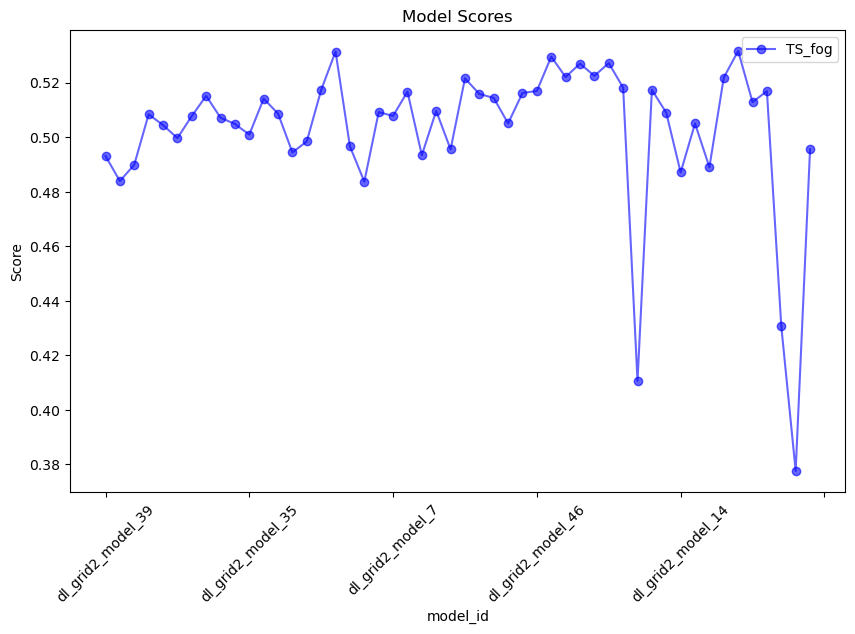

In [13]:
df = pd.DataFrame(model_score_list)

# Set the model ID as the index
df.set_index('model_id', inplace=True)

# Plot the scores
plt.figure(figsize=(10, 6))
df['TS_fog'].plot(kind='line', marker='o', color='blue', alpha=0.6, label='TS_fog')
# df['TS_mist'].plot(kind='line', marker='o', color='red', alpha=0.6, label='TS_mist')
plt.ylabel('Score')
plt.title('Model Scores')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [15]:
# Find the model_id with the maximum TS_fog score
best_model_id = df['TS_fog'].idxmax()

print("The model_id with the maximum TS_fog score is:", best_model_id)

The model_id with the maximum TS_fog score is: dl_grid2_model_12


In [14]:
df['TS_fog'].max()

0.5316024033343558

In [18]:
# Get the best model
best_model = h2o.get_model(best_model_id)

# Save the model
model_path = h2o.save_model(model=best_model, path="/mnt/f/github/pythonScript/seafog/src/h2o/h2o_model_v4_best", force=True)

print("The model is saved to:", model_path)

The model is saved to: /mnt/f/github/pythonScript/seafog/src/h2o/h2o_model_v4_best/dl_grid_model_20


In [16]:
best_model = h2o.get_model(best_model_id)
print('#### ==================训练集==========')
getScore(h2o.H2OFrame(train_x_scaled, column_names=x_columns), train_y, best_model)
print('#### ===============验证集==========')
getScore(h2o.H2OFrame(valid_x_scaled, column_names=x_columns), valid_y, best_model)
print('#### ===================测试集-预报==========')
getScore(h2o.H2OFrame(test_x_scaled, column_names=x_columns), test_y, best_model)
print('#### ===================测试集+验证==========')
getScore(h2o.H2OFrame(valid_test_x_scaled, column_names=x_columns), valid_test_y, best_model)

#### ==================训练集==========
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
* 实况为雾时: 比例: 雾:0.9014211465065879, 轻雾0.09754959309053017, 无雾0.0010292604028819291
* 实况为轻雾时: 比例: 雾:0.1356066563101334, 轻雾0.68218228777098, 无雾0.18221105591888662
* 实况为无雾时: 比例: 雾:0.009218593173638148, 轻雾0.27545181974517813, 无雾0.7153295870811837
* TS评分: 雾: 0.7873875483730463, 轻雾及雾: 0.7951955229101084
#### ===============验证集==========
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
* 实况为雾时: 比例: 雾:0.7240893224738209, 轻雾0.2758211760494048, 无雾8.950147677436678e-05
* 实况为轻雾时: 比例: 雾:0.23451624451803454, 轻雾0.7391703213103016, 无雾0.026313434171663833
* 实况为无雾时: 比例: 雾:0.007160118141949342, 轻雾0.247314955696769, 无雾0.7455249261612816
* TS评分: 

{'TS_fog': 0.5573947852428865, 'TS_mist': 0.8753792600022843}

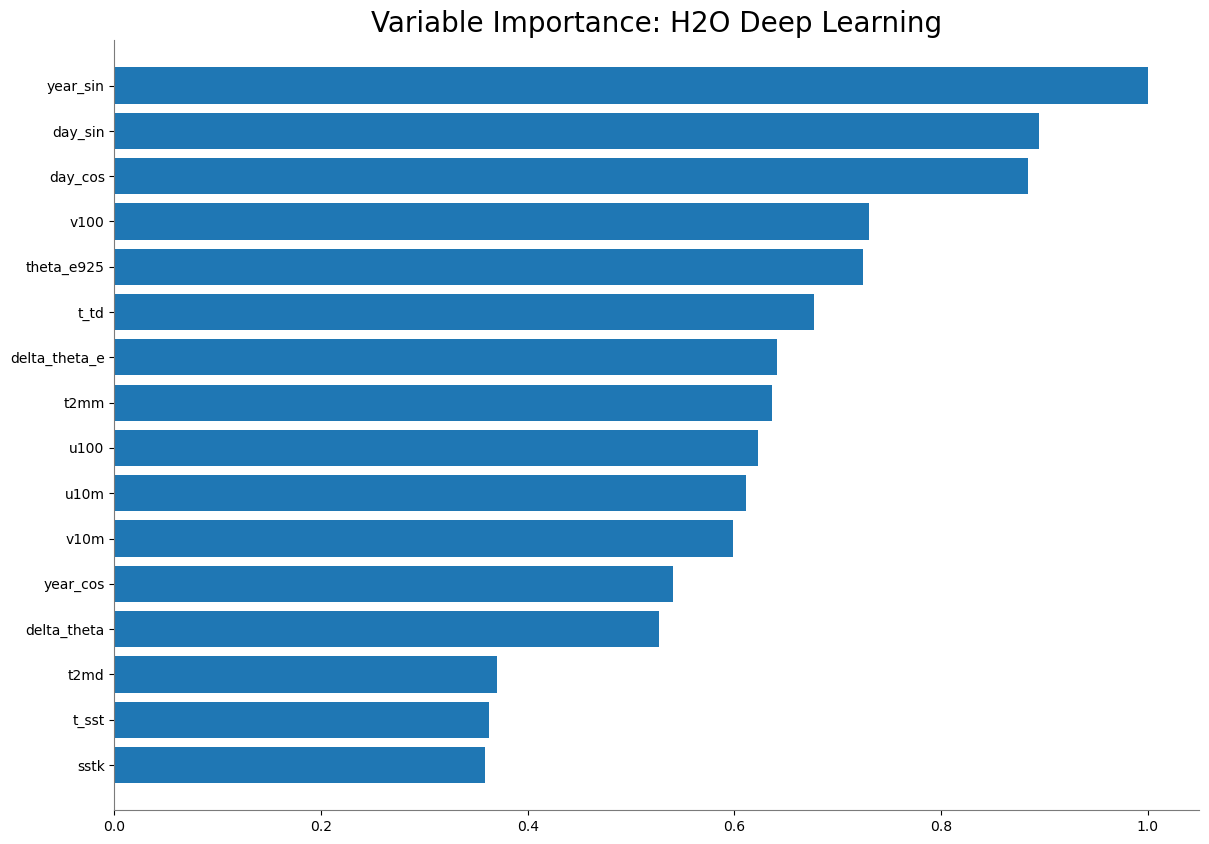

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: dl_grid2_model_12


Status of Neuron Layers: predicting target, regression, gaussian distribution, Quadratic loss, 15,721 weights/biases, 193.7 KB, 4,700,547 training samples, mini-batch size 1
    layer    units    type       dropout    l1     l2    mean_rate             rate_rms             momentum    mean_weight             weight_rms            mean_bias              bias_rms
--  -------  -------  ---------  ---------  -----  ----  --------------------  -------------------  ----------  ----------------------  --------------------  ---------------------  -----------------------
    1        17       Input      0.0
    2        60       Rectifier  0.0        0.001  0.0   0.04250433212243176   0.09527024626731873  0.0         -0.0007787524921384309  0.08676442503929138   0.10265733464542746    0.1292039155960083
    3        120      Rectifier  0.0        0.001  0.0   0.14598101070653177   0.1679375171661377   0.0         -0.004262239505151879   0.033332377672195435  0.08095505925040679    0.19369637966156006
    4        60       Rectifier  0.0        0.001  0.0   0.19072158611489512   0.14237183332443237  0.0         -0.00640819765645922    0.046179041266441345  0.10956854086209698    0.19232243299484253
    5        1        Linear                0.001  0.0   0.011335115483476935  0.01882125437259674  0.0         0.011747931780150603    0.13446128368377686   -0.052911831314264704  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.15765958169813965
RMSE: 0.39706369979908723
MAE: 0.3065409292976718
RMSLE: 0.17362191644170297
Mean Residual Deviance: 0.15765958169813965

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 0.2713216288453247
RMSE: 0.5208854277529029
MAE: 0.4076086013483212
RMSLE: 0.28295582079038006
Mean Residual Deviance: 0.2713216288453247

Scoring History: 
    timestamp            duration          training_speed    epochs    iterations    samples      training_rmse    training_deviance    training_mae    training_r2    validation_rmse    validation_deviance    validation_mae    validation_r2
--  -------------------  ----------------  ----------------  --------  ------------  -----------  ---------------  -------------------  --------------  -------------  -----------------  ---------------------  ----------------  ---------------
    2023-05-18 10:42:33  0.000 sec                           0         0             0            nan              nan                  nan             nan            nan                nan                    nan               nan
    2023-05-18 10:42:34  3 min 27.276 sec  94158 obs/sec     0.213289  1             100090       0.397064         0.15766              0.306541        0.779811       0.520885           0.271322               0.407609          0.683031
    2023-05-18 10:42:39  3 min 32.565 sec  319735 obs/sec    4.04993   19            1.90051e+06  0.373851         0.139765             0.289497        0.804803       0.631696           0.39904                0.482469          0.533824
    2023-05-18 10:42:44  3 min 37.565 sec  356694 obs/sec    8.09818   38            3.80022e+06  0.356113         0.126816             0.273129        0.822887       0.638968           0.40828                0.491831          0.523031
    2023-05-18 10:42:47  3 min 40.255 sec  359478 obs/sec    10.0167   47            4.70055e+06  0.355291         0.126232             0.275353        0.823703       0.639355           0.408774               0.492996          0.522453
    2023-05-18 10:42:47  3 min 40.520 sec  359451 obs/sec    10.0167   47            4.70055e+06  0.397064         0.15766              0.306541        0.779811       0.520885           0.271322               0.407609          0.683031

Variable Importances: 
variable       relative_importance    scaled_importance    percentage
-------------  ---------------------  ---------

,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
,1,17,Input,0.0,,,,,,,,,
,2,60,Rectifier,0.0,0.001,0.0,0.0425043,0.0952702,0.0,-0.0007788,0.0867644,0.1026573,0.1292039
,3,120,Rectifier,0.0,0.001,0.0,0.1459810,0.1679375,0.0,-0.0042622,0.0333324,0.0809551,0.1936964
,4,60,Rectifier,0.0,0.001,0.0,0.1907216,0.1423718,0.0,-0.0064082,0.0461790,0.1095685,0.1923224
,5,1,Linear,,0.001,0.0,0.0113351,0.0188213,0.0,0.0117479,0.1344613,-0.0529118,0.0000000


<Figure size 640x480 with 0 Axes>

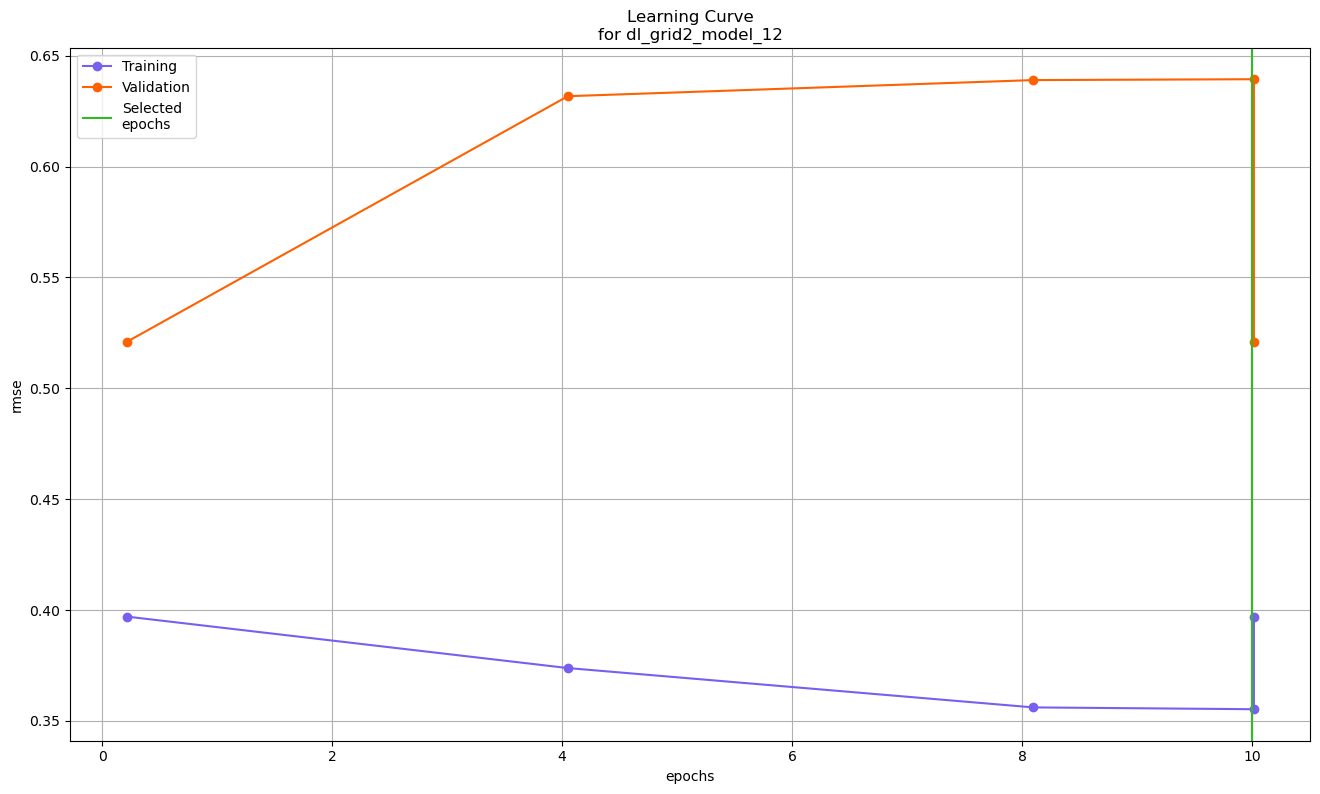

In [17]:

ra_plot = best_model.varimp_plot(num_of_features=-1)
learning_curve_plot = best_model.learning_curve_plot()
# build the hit ratio table:
best_model.show()
best_model.summary()